In [112]:
import tensorflow as tf
from sklearn.cross_validation import train_test_split
import sys
from sklearn.utils import shuffle
import h5py
import time
import seaborn as ses

from IPython import display
import pylab as pl

%matplotlib inline

# Model of one layer GRU


### load X,Y Data from folder /Data

In [68]:
def restore (nameOfFile,nameOfDataset):
    h5f = h5py.File(nameOfFile,'r')
    matrix = h5f[nameOfDataset][:]
    h5f.close()
    return matrix

In [142]:
X = restore("Data/data_matrix_X.h5","X")
Y = restore("Data/data_matrix_Y.h5","Y")

x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.40,random_state=42)
x_validate,x_test,y_validate,y_test = train_test_split(x_test,y_test,test_size=0.50,random_state=42)

In [70]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
print(x_validate.shape)
print(y_validate.shape)

(700, 83, 27)
(700, 2)
(234, 83, 27)
(234, 2)
(233, 83, 27)
(233, 2)


### model tuning parameters

In [71]:
# size of input vector
input_size = 27
# nimber of hidden unit
hidden_size = 110
# number of output vector
output_size = 2

learn_rate = 0.001

batch_size = 700
epoch_number = 100

## Design of RGU cell

In [72]:
class GruCell(object):
    
    def __init__(self,input_size , hidden_size , output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        #weight of input vector
        self.ui = tf.Variable(
            tf.random_normal([self.input_size,self.hidden_size],
                             mean=0,stddev=0.01,seed=1))
        
        #weight of rest gate
        self.wr = tf.Variable(
            tf.random_normal([self.input_size,self.hidden_size],
                             mean=0,stddev=0.01,seed=1))
        self.br = tf.Variable(
            tf.ones([self.hidden_size]))
        
        #weight of update gate
        self.wz = tf.Variable(
            tf.random_normal([self.input_size,self.hidden_size],
                             mean=0,stddev=0.01,seed=1))
        self.bz = tf.Variable(
            tf.ones([self.hidden_size]))

        #weight of hidden layer
        self.wh = tf.Variable(
            tf.random_normal([self.hidden_size,self.hidden_size],
                             mean=0,stddev=0.01,seed=1))
        
        #weight of output layer
        self.vo = tf.Variable(
            tf.random_normal([self.hidden_size,output_size],
                             mean=0,stddev=0.01,seed=1))
        self.bo = tf.Variable(
            tf.ones([self.output_size]))
        
        #define shape of input matrix  
        
        self.inputs_matrix = tf.placeholder(
            dtype=tf.float32 ,shape=[None,None,self.input_size])
        
        #prepare input matrix to feed model 
        # it will make matrix as [m,t,n] --> [t,m,n]
        # t : number of time
        # n : length of input vector
        # m : number of sentences
        self.feed_marix = tf.transpose(
            self.inputs_matrix,perm=[1,0,2])
        
        #prepare initial state as matrix of zerose (batch_size,hidden_size)
        self.initial_state = tf.matmul(
            self.feed_marix[0],
            tf.zeros([self.input_size,self.hidden_size]))
        
        
    def gru(self, previous_hidden_state, x):
        """gur cell that compute  curent state at time t using
           previous state at t-1 and input vector x
    
        Args:
            previous_hidden_state (matrix): previous_state at (t-1) .
            x (vector): input vector of char.

        Returns:
            current_hidden_state: current state

        Note:
            returned matrix size (batch_number , hidden_unit_size)
        """
        #compute update gate that update state_at_(t-1)
        z= tf.sigmoid(tf.matmul(x,self.wz)+ self.bz)
        #compute reset gate 
        r= tf.sigmoid(tf.matmul(x,self.wr)+ self.br)  
        #compute internal memory
        h_= tf.tanh(tf.matmul(x,self.ui) + tf.matmul(previous_hidden_state,self.wh)*r)
        #compute current state
        current_hidden_state = tf.multiply((1-z),h_) + tf.multiply(previous_hidden_state,z)
        return current_hidden_state  
        
    def get_states(self):
        """get all state of batch_number example it accumulate 
           all states of one sentence matrix like :
           S0 = initial_state + x0
           S1 = S0 + x1
           S2 = S1 + x2
                .
                .
           Sn = Sn-1 + xn
           
           and for batch_number
    
        Returns:
            all_stats: all state of m example

        Note:
            returned matrix size (number_time_steps ,batch_number , input_size )
        """
        # apply gru function on all matrix of all batch like
        #   state_0 =  gru(initial_state,feed_marix[0])
        #   state_1 =  gru(state_0,feed_matrix[1])
        all_stats = tf.scan(self.gru,self.feed_marix,self.initial_state,name="stats")
        return all_stats        
        
    def get_output(self,hidden_stat):
        """apply the hidden_state on RELU activation 
           function to compute output
        
        Args:
            hidden_stat (matrix): state at time t
        
        Returns:
            output: output matrix

        Note:
            returned matrix size (batch_number , output_size )
        """
        output = tf.nn.relu(tf.matmul(hidden_stat,self.vo)+self.bo)
        return output
    
        
    def get_outputs(self):
        """get all output for all states
    
        Returns:
            all_outputs: output matrix for all state  

        Note:
            returned matrix size (state_numbers , batch_number , output_size )
        """
        #get all states for every time step 
        all_stats = self.get_states()
        #compute output matrix for all states
        all_outputs = tf.map_fn(self.get_output,all_stats)
        return all_outputs

## Define Model

In [73]:
# define GruCell class
rnn = GruCell(hidden_size=hidden_size,input_size=input_size,output_size=output_size)

#get all outputs 
outputs = rnn.get_outputs()

#get last state for batch
last_output = outputs[-1]

#apply softmax on all last states
output = tf.nn.softmax(last_output)

#define shape of y
y = tf.placeholder(tf.float32,shape=[None,output_size])

#compute Cost_function 
cross_entropy = -tf.reduce_sum(y * tf.log(output))

#use AdamOptmizer to reduece error
optmizer_step = tf.train.AdamOptimizer(learning_rate=learn_rate).minimize(cross_entropy)

#compute accuracy
correct_prediction = tf.equal(tf.argmax(y,1),tf.argmax(output,1))
accuracy = (tf.reduce_sum(tf.cast(correct_prediction,tf.float32)))*100

## Train Model

In [74]:
sess = tf.Session()
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


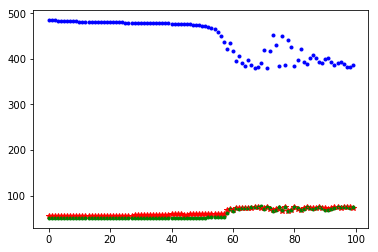

Iteration: 99   Loss: 385.842     Train-Accuracy: 73.4285714286      Test-Accuracy: 75.2136752137

--- 4.454698848724365 minute ---


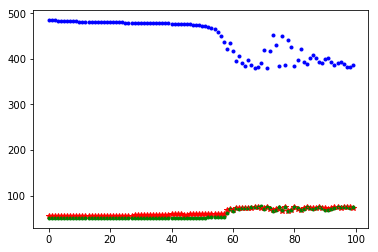

In [75]:
start_time = time.time()
for epoch in range(epoch_number):
    start = 0
    end = batch_size
    batchs_num = int(X.shape[0]/batch_size)
    for i in range(batchs_num):
        X = x_train[start:end]
        Y = y_train[start:end]
        start=end
        end=end+batch_size
        sess.run(optmizer_step,feed_dict={rnn.inputs_matrix:X,y:Y})
    
    loss = sess.run(cross_entropy,feed_dict={rnn.inputs_matrix:X,y:Y})
    train_accuracy = sess.run(accuracy,feed_dict={rnn.inputs_matrix:x_train,y:y_train}) / len(x_train)
    test_acuuracy = sess.run(accuracy,feed_dict={rnn.inputs_matrix:x_test,y:y_test}) / len(y_test)
    pl.plot([epoch],loss,'b.')
    pl.plot([epoch],train_accuracy,'r*')
    pl.plot([epoch],test_acuuracy,'g.')
    display.clear_output(wait=True)
    display.display(pl.gcf())
    
    sys.stdout.flush()
    print("\rIteration: %s   Loss: %s     Train-Accuracy: %s      Test-Accuracy: %s"%(epoch,loss,train_accuracy,test_acuuracy))
    sys.stdout.flush()

print("\n--- %s minute ---" % ((time.time() - start_time)/60))

## Test model 

In [162]:
#get all outputs of test set
test_outputs = rnn.get_outputs()
sess.run(test_outputs,feed_dict={rnn.inputs_matrix:x_test})
#get last state of last time step
last_test_output = test_outputs[-1]


In [163]:
#apply softmax on last_test_output
y_predict = sess.run(tf.nn.softmax(last_test_output),feed_dict={rnn.inputs_matrix:x_test})

In [176]:
#compute accuracy
correct_prediction = tf.equal(tf.argmax(y_predict,1),tf.argmax(y_test,1))
accuracy = (tf.reduce_sum(tf.cast(correct_prediction,tf.float32))*100)/len(x_test)
print("Accuracy of test set :: %s "%(sess.run(accuracy)))


Accuracy of test set :: 75.2137 


In [177]:
num = 10
print(y_test[num])
print(y_predict[num])

[ 0.  1.]
[ 0.2626358   0.73736423]
